# Email Spam Detection - Model Training

This notebook trains a machine learning model to classify emails as spam or ham (legitimate).

**Pipeline:**
1. Load and preprocess data
2. Text cleaning and vectorization (TF-IDF)
3. Train multiple models
4. Evaluate and compare performance
5. Save best model and vectorizer

**Project:** Email Spam Detection System  
**Purpose:** Engineering Degree Project  
**Date:** December 2025

## 1. Import Required Libraries

In [1]:
# Data handling
import pandas as pd
import numpy as np

# Text preprocessing
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# Model training
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Evaluation
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report)

# Model persistence
import joblib

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Settings
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


## 2. Download NLTK Data

In [2]:
# Download required NLTK data
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('punkt', quiet=True)

print("✅ NLTK data downloaded successfully!")

✅ NLTK data downloaded successfully!


## 3. Load Dataset

In [3]:
# Try to load cleaned dataset from EDA, otherwise load original
try:
    df = pd.read_csv('spam_cleaned.csv')
    print("✅ Loaded cleaned dataset from EDA")
except:
    try:
        df = pd.read_csv('spam.csv', encoding='latin-1')
        # Clean column names
        if 'v1' in df.columns and 'v2' in df.columns:
            df = df[['v1', 'v2']]
            df.columns = ['label', 'message']
        print("✅ Loaded original dataset")
    except:
        print("❌ Dataset not found. Creating sample data for demonstration.")
        df = pd.DataFrame({
            'label': ['ham', 'spam', 'ham', 'spam', 'ham'] * 100,
            'message': [
                'Hello, how are you?',
                'WINNER! You have won $1000. Click here now!',
                'Meeting at 3pm tomorrow',
                'FREE entry to win cash prizes! Text WIN to 12345',
                'Can you call me when you are free?'
            ] * 100
        })

print(f"\n📊 Dataset shape: {df.shape}")
print(f"   Columns: {df.columns.tolist()}")
print(f"\n   First few rows:")
print(df.head())

✅ Loaded cleaned dataset from EDA

📊 Dataset shape: (5169, 2)
   Columns: ['label', 'message']

   First few rows:
  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


## 4. Text Preprocessing Functions

In [4]:
# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    """
    Clean and preprocess email text.
    
    Steps:
    1. Convert to lowercase
    2. Remove URLs
    3. Remove HTML tags
    4. Remove email addresses
    5. Remove punctuation
    6. Remove digits
    7. Remove extra whitespace
    8. Remove stopwords
    9. Lemmatize
    """
    if not isinstance(text, str):
        return ""
    
    # 1. Lowercase
    text = text.lower()
    
    # 2. Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    
    # 3. Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # 4. Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    # 5. Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # 6. Remove digits
    text = re.sub(r'\d+', '', text)
    
    # 7. Remove extra whitespace
    text = ' '.join(text.split())
    
    # 8. Remove stopwords and 9. Lemmatize
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    
    return ' '.join(words)

# Test the function
sample_text = "WINNER! You've WON $1,000! Visit http://spam.com NOW!!!"
print("Original:", sample_text)
print("Cleaned:", clean_text(sample_text))
print("\n✅ Text preprocessing function created!")

Original: WINNER! You've WON $1,000! Visit http://spam.com NOW!!!
Cleaned: winner youve visit

✅ Text preprocessing function created!
Cleaned: winner youve visit

✅ Text preprocessing function created!


## 5. Preprocess All Text Data

In [5]:
# Apply preprocessing to all messages
print("🔄 Preprocessing all email messages...")
df['cleaned_message'] = df['message'].apply(clean_text)

# Remove empty messages after cleaning
df = df[df['cleaned_message'].str.len() > 0]

print(f"✅ Preprocessing complete!")
print(f"   Dataset size after cleaning: {len(df)}")
print(f"\n   Sample cleaned messages:")
print(df[['message', 'cleaned_message']].head())

🔄 Preprocessing all email messages...
✅ Preprocessing complete!
   Dataset size after cleaning: 5163

   Sample cleaned messages:
                                             message  \
0  Go until jurong point, crazy.. Available only ...   
1                      Ok lar... Joking wif u oni...   
2  Free entry in 2 a wkly comp to win FA Cup fina...   
3  U dun say so early hor... U c already then say...   
4  Nah I don't think he goes to usf, he lives aro...   

                                     cleaned_message  
0  go jurong point crazy available bugis n great ...  
1                            ok lar joking wif u oni  
2  free entry wkly comp win fa cup final tkts st ...  
3                u dun say early hor u c already say  
4           nah dont think go usf life around though  


## 6. Encode Labels

In [6]:
# Convert labels to binary: ham=0, spam=1
df['label_encoded'] = df['label'].map({'ham': 0, 'spam': 1})

print("📊 Label encoding:")
print(df['label'].value_counts())
print(f"\n   ham → 0, spam → 1")
print("✅ Labels encoded!")

📊 Label encoding:
label
ham     4510
spam     653
Name: count, dtype: int64

   ham → 0, spam → 1
✅ Labels encoded!


## 7. Feature Extraction with TF-IDF

In [7]:
# Create TF-IDF vectorizer
vectorizer = TfidfVectorizer(
    max_features=3000,  # Use top 3000 features
    min_df=3,          # Minimum document frequency
    max_df=0.8,        # Maximum document frequency
    ngram_range=(1, 2) # Use unigrams and bigrams
)

# Fit and transform the cleaned messages
X = vectorizer.fit_transform(df['cleaned_message'])
y = df['label_encoded']

print("✅ TF-IDF vectorization complete!")
print(f"   Feature matrix shape: {X.shape}")
print(f"   Number of features: {X.shape[1]}")
print(f"   Number of samples: {X.shape[0]}")

# Show top features
feature_names = vectorizer.get_feature_names_out()
print(f"\n   Sample features: {feature_names[:20]}")

✅ TF-IDF vectorization complete!
   Feature matrix shape: (5163, 3000)
   Number of features: 3000
   Number of samples: 5163

   Sample features: ['abi' 'abiola' 'able' 'able get' 'abt' 'abta' 'abta complimentary' 'ac'
 'acc' 'accept' 'access' 'accident' 'accidentally' 'account'
 'account statement' 'ache' 'across' 'across sea' 'action' 'activate']


## 8. Split Data into Train and Test Sets

In [8]:
# Split data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("✅ Data split complete!")
print(f"   Training set: {X_train.shape[0]} samples")
print(f"   Test set: {X_test.shape[0]} samples")
print(f"\n   Training label distribution:")
print(y_train.value_counts())
print(f"\n   Test label distribution:")
print(y_test.value_counts())

✅ Data split complete!
   Training set: 4130 samples
   Test set: 1033 samples

   Training label distribution:
label_encoded
0    3608
1     522
Name: count, dtype: int64

   Test label distribution:
label_encoded
0    902
1    131
Name: count, dtype: int64


## 9. Train Multiple Models

In [9]:
# Initialize models
models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='linear', probability=True, random_state=42)
}

# Train and evaluate each model
results = {}

print("🔄 Training models...\n")
for name, model in models.items():
    print(f"Training {name}...")
    
    # Train model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'predictions': y_pred
    }
    
    print(f"   ✅ {name} trained!")
    print(f"      Accuracy: {accuracy:.4f}")
    print(f"      Precision: {precision:.4f}")
    print(f"      Recall: {recall:.4f}")
    print(f"      F1-Score: {f1:.4f}\n")

🔄 Training models...

Training Naive Bayes...
   ✅ Naive Bayes trained!
      Accuracy: 0.9748
      Precision: 0.9907
      Recall: 0.8092
      F1-Score: 0.8908

Training Logistic Regression...
   ✅ Logistic Regression trained!
      Accuracy: 0.9497
      Precision: 0.9877
      Recall: 0.6107
      F1-Score: 0.7547

Training Random Forest...
   ✅ Random Forest trained!
      Accuracy: 0.9826
      Precision: 1.0000
      Recall: 0.8626
      F1-Score: 0.9262

Training SVM...
   ✅ Random Forest trained!
      Accuracy: 0.9826
      Precision: 1.0000
      Recall: 0.8626
      F1-Score: 0.9262

Training SVM...
   ✅ SVM trained!
      Accuracy: 0.9845
      Precision: 0.9915
      Recall: 0.8855
      F1-Score: 0.9355

   ✅ SVM trained!
      Accuracy: 0.9845
      Precision: 0.9915
      Recall: 0.8855
      F1-Score: 0.9355



## 10. Compare Model Performance

In [10]:
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results],
    'Precision': [results[m]['precision'] for m in results],
    'Recall': [results[m]['recall'] for m in results],
    'F1-Score': [results[m]['f1_score'] for m in results]
})

print("📊 Model Performance Comparison:")
print(comparison_df.to_string(index=False))

# Find best model
best_model_name = comparison_df.loc[comparison_df['F1-Score'].idxmax(), 'Model']
print(f"\n🏆 Best Model: {best_model_name}")

📊 Model Performance Comparison:
              Model  Accuracy  Precision   Recall  F1-Score
        Naive Bayes  0.974831   0.990654 0.809160  0.890756
Logistic Regression  0.949661   0.987654 0.610687  0.754717
      Random Forest  0.982575   1.000000 0.862595  0.926230
                SVM  0.984511   0.991453 0.885496  0.935484

🏆 Best Model: SVM


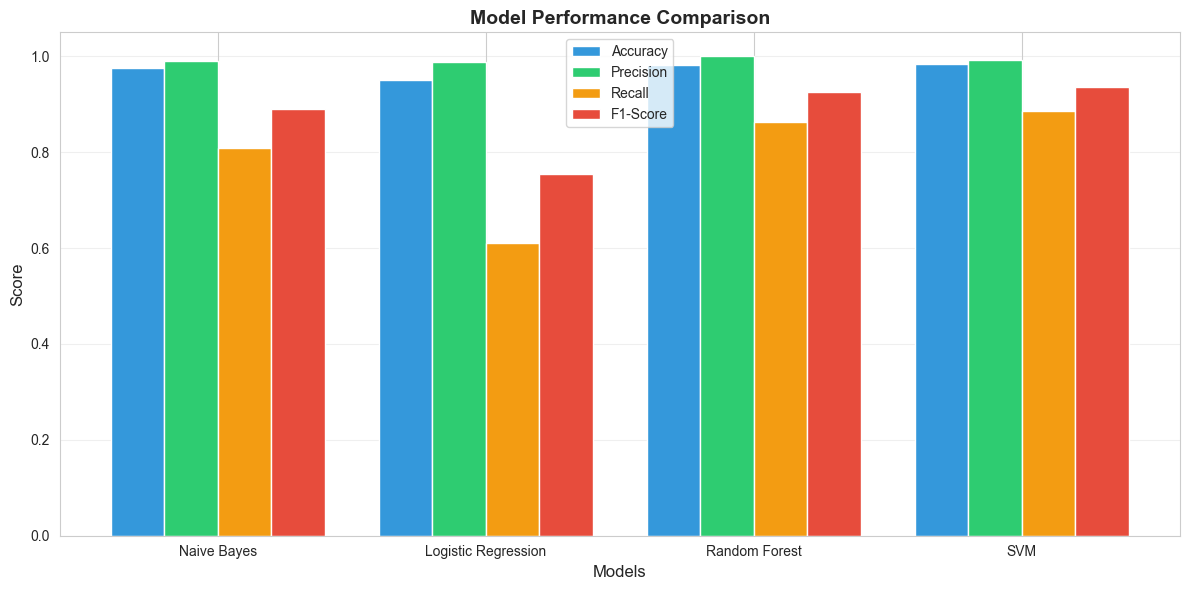

In [11]:
# Visualize model comparison
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(comparison_df))
width = 0.2

ax.bar(x - 1.5*width, comparison_df['Accuracy'], width, label='Accuracy', color='#3498db')
ax.bar(x - 0.5*width, comparison_df['Precision'], width, label='Precision', color='#2ecc71')
ax.bar(x + 0.5*width, comparison_df['Recall'], width, label='Recall', color='#f39c12')
ax.bar(x + 1.5*width, comparison_df['F1-Score'], width, label='F1-Score', color='#e74c3c')

ax.set_xlabel('Models', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Model'])
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Detailed Evaluation of Best Model

In [12]:
# Get best model
best_model = results[best_model_name]['model']
best_predictions = results[best_model_name]['predictions']

# Classification report
print(f"📋 Classification Report for {best_model_name}:")
print(classification_report(y_test, best_predictions, target_names=['Ham', 'Spam']))

📋 Classification Report for SVM:
              precision    recall  f1-score   support

         Ham       0.98      1.00      0.99       902
        Spam       0.99      0.89      0.94       131

    accuracy                           0.98      1033
   macro avg       0.99      0.94      0.96      1033
weighted avg       0.98      0.98      0.98      1033



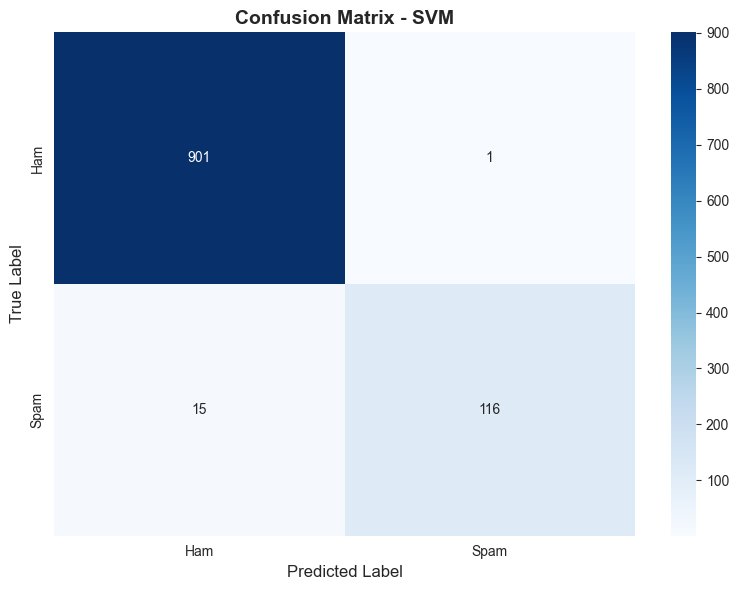


📊 Confusion Matrix Breakdown:
   True Negatives (Ham correctly classified): 901
   False Positives (Ham incorrectly as Spam): 1
   False Negatives (Spam incorrectly as Ham): 15
   True Positives (Spam correctly classified): 116


In [13]:
# Confusion matrix
cm = confusion_matrix(y_test, best_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# Calculate additional metrics
tn, fp, fn, tp = cm.ravel()
print(f"\n📊 Confusion Matrix Breakdown:")
print(f"   True Negatives (Ham correctly classified): {tn}")
print(f"   False Positives (Ham incorrectly as Spam): {fp}")
print(f"   False Negatives (Spam incorrectly as Ham): {fn}")
print(f"   True Positives (Spam correctly classified): {tp}")

## 12. Test Model with Sample Emails

In [14]:
# Test samples
test_emails = [
    "Congratulations! You have won $1,000,000! Click here to claim your prize NOW!!!",
    "Hi John, can we reschedule our meeting to 3pm tomorrow?",
    "FREE! Win big money playing casino games. Text WIN to 12345 now!",
    "Your Amazon order has been shipped and will arrive in 2-3 business days.",
    "URGENT: Your account will be suspended unless you verify your password immediately!",
    "Hey, let's grab coffee this weekend. Are you free on Saturday?",
]

print("🧪 Testing model with sample emails:\n")

for i, email in enumerate(test_emails, 1):
    # Preprocess
    cleaned = clean_text(email)
    
    # Vectorize
    email_vector = vectorizer.transform([cleaned])
    
    # Predict
    prediction = best_model.predict(email_vector)[0]
    probability = best_model.predict_proba(email_vector)[0]
    
    label = "SPAM" if prediction == 1 else "HAM"
    confidence = probability[prediction] * 100
    
    print(f"{i}. Email: {email[:60]}...")
    print(f"   Prediction: {label} (Confidence: {confidence:.2f}%)\n")

🧪 Testing model with sample emails:

1. Email: Congratulations! You have won $1,000,000! Click here to clai...
   Prediction: SPAM (Confidence: 99.69%)

2. Email: Hi John, can we reschedule our meeting to 3pm tomorrow?...
   Prediction: HAM (Confidence: 99.01%)

3. Email: FREE! Win big money playing casino games. Text WIN to 12345 ...
   Prediction: SPAM (Confidence: 99.27%)

4. Email: Your Amazon order has been shipped and will arrive in 2-3 bu...
   Prediction: HAM (Confidence: 61.95%)

5. Email: URGENT: Your account will be suspended unless you verify you...
   Prediction: HAM (Confidence: 63.88%)

6. Email: Hey, let's grab coffee this weekend. Are you free on Saturda...
   Prediction: HAM (Confidence: 96.70%)



## 13. Save Model and Vectorizer

In [15]:
# Save the best model
joblib.dump(best_model, 'model.pkl')
print(f"✅ Model saved as 'model.pkl'")

# Save the vectorizer
joblib.dump(vectorizer, 'vectorizer.pkl')
print(f"✅ Vectorizer saved as 'vectorizer.pkl'")

# Also save with alternative names for consistency
joblib.dump(best_model, 'trained_model.pkl')
print(f"✅ Model also saved as 'trained_model.pkl'")

print(f"\n📦 Model Details:")
print(f"   Model type: {best_model_name}")
print(f"   Accuracy: {results[best_model_name]['accuracy']:.4f}")
print(f"   F1-Score: {results[best_model_name]['f1_score']:.4f}")
print(f"\n📁 Files saved in ml_model/ directory")

✅ Model saved as 'model.pkl'
✅ Vectorizer saved as 'vectorizer.pkl'
✅ Model also saved as 'trained_model.pkl'

📦 Model Details:
   Model type: SVM
   Accuracy: 0.9845
   F1-Score: 0.9355

📁 Files saved in ml_model/ directory


## 14. Next Steps

### ✅ Model Training Complete!

**What you have now:**
- Trained ML model: `model.pkl` and `trained_model.pkl`
- TF-IDF vectorizer: `vectorizer.pkl`
- Model performance metrics and evaluation

### 📋 Next Steps:

1. **Copy Model Files to Backend:**
   ```
   Copy model.pkl and vectorizer.pkl to:
   backend/predictor/ml/
   ```

2. **Start Django Backend:**
   ```bash
   cd backend
   python manage.py migrate
   python manage.py runserver
   ```

3. **Test API Endpoint:**
   - Endpoint: `http://localhost:8000/api/predict/`
   - Method: POST
   - Body: `{"email_text": "your email text here"}`

4. **Deploy Frontend:**
   - Open `frontend/index.html` in browser
   - Test the complete system

5. **Optional Enhancements:**
   - Add confidence score visualization
   - Implement email logging to database
   - Create admin dashboard
   - Add authentication

### 🎓 For Viva/Presentation:
- Explain TF-IDF vectorization
- Discuss model selection process
- Show confusion matrix
- Demonstrate API functionality
- Explain end-to-end data flow